# Module Importing
To see requirements, please see Requirements.txt

In [1]:
try: 
    from skimage.feature import hog
    from skimage.io import imread, imshow
    from skimage.transform import resize
    from sklearn import svm, metrics
    from sklearn.decomposition import PCA
    from sklearn.experimental import enable_halving_search_cv
    from sklearn.model_selection import HalvingGridSearchCV
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from tqdm import tqdm
    import math
    import matplotlib.pyplot as plt
    import numpy
    import os
    import pandas
    import pywt
    
except ImportError:
    print('Please download dependencies in Requirements.txt')

# Data Preprocessing

In [2]:
training_dataset = pandas.read_csv('./dataset/label.csv')
training_dataset.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


# Preprocessing Training Images

Using pywavelets, the training images reduced from (512, 512) to (256, 256), which reduces noise.

In [3]:
training_path = './dataset/image'

train_images = []
for filename in tqdm(training_dataset['file_name']):
    image = imread(os.path.join(training_path, filename), as_gray=True)   # Converts image to greyscale, then gets data
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    train_images.append(cA)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:56<00:00, 52.97it/s]


# Preprocessing Test Images

Same method is carried out on test images

In [4]:
testing_dataset = pandas.read_csv('./test/label.csv')
test_path = './test/image'

test_images = []
for filename in tqdm(testing_dataset['file_name']):
    image = imread(os.path.join(test_path, filename,), as_gray=True)   # Converts image to greyscale, then gets data
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    test_images.append(cA)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.10it/s]


# Feature Extraction

Uses Histogram of Orientated Gradients (HOG) to detect features in each image.

The image must be resized to (128, 64) since that is the detection window of HOG.

In [5]:
def hog_FE(image_data):

    hog_features = []
    
    for i in tqdm(range(len(image_data))):
        resized = resize(image_data[i], (128, 64))
        # Extract Histogram of Oriented Gradients (HOG) for the image
        fd = hog(resized, orientations = 9, pixels_per_cell = (8, 8), cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
        hog_features.append(fd)

    return hog_features

# Convert Label to Number

For each image, it checks the "label" status, and assigns it a 0 if there is no tumor, and a 1 if there is a glioma tumor, 2 if there is a meningioma tumor or 3 if there is a pituitary tumor

In [6]:
def label_to_number(dataset):
    tumortype = []
    for label in dataset['label']:
        if 'no_tumor' in label:
            tumortype.append(0)
        elif 'glioma_tumor' in label:
            tumortype.append(1)
        elif 'meningioma_tumor' in label:
            tumortype.append(2)
        elif 'pituitary_tumor' in label:
            tumortype.append(3)
    return tumortype

# Carry out Hog FE on both sets of images# Set Creation

In [7]:
train = pandas.DataFrame(data=hog_FE(train_images))
train['tumor_binary'] = label_to_number(training_dataset)

test = pandas.DataFrame(data=hog_FE(test_images))
test['tumor_binary'] = label_to_number(testing_dataset)
   
    
    
Training_Dataset = train.drop('tumor_binary', axis=1)  # All features apart from tumor type
Training_Tumor = train['tumor_binary']  # Training images tumor type

Test_Dataset = test.drop('tumor_binary', axis=1)  # All features apart from tumor type
Test_Tumor = test['tumor_binary']  # Test images tumor type

scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
scaler.fit(Training_Dataset) # Fits scalar to the training dataset

Training_Dataset = scaler.transform(Training_Dataset) # Transforms Training_Dataset with scalar
Test_Dataset = scaler.transform(Test_Dataset) # Transforms Test_Dataset with scalar

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 120.00it/s]


In [8]:
pandas.Series(Training_Tumor).value_counts()

1    860
2    855
3    831
0    454
Name: tumor_binary, dtype: int64

# SVM Classifier

Uses the Halving Grid Search Cross-Validation from the scikit-learn module to generate a SVM classifier.

Different parameters were tested, and when the best solution was identified, it was used to predict the labels in the test set.# SVM Classifier

In [9]:
pca = PCA()
svc = svm.SVC(probability=True)

pca_svc = Pipeline(steps=[('pca', pca), ('svc', svc)])

params = [{'svc__C': [1, 10, 100], 'svc__kernel': ['rbf'], 'svc__gamma': ['auto'],
           "pca__n_components": [0.96, 0.97, 0.98, 0.99]}, # Parameters for HG-SVC
          {'svc__C': [1, 10, 100], 'svc__kernel': ['poly'], 'svc__gamma': ['auto'],
           "pca__n_components": [0.96, 0.97, 0.98, 0.99]}] # Parameters for HG-SVC

classifier = HalvingGridSearchCV(pca_svc, params, factor = 2, verbose= 3, return_train_score=True)
classifier.fit(Training_Dataset, Training_Tumor)
print(classifier.best_params_)

results = pandas.DataFrame.from_dict(
    classifier.cv_results_).sort_values(by=['rank_test_score'])
results = results[['params', 'mean_train_score',
                   'mean_test_score', 'rank_test_score']]

Tumor_Prediction = classifier.predict(Test_Dataset)



n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 187
max_resources_: 3000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 187
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.270) total time=   0.2s
[CV 2/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.270) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.243) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.297) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.135) total time=   0.0s
[CV 1/5] END pca__n_components=0.96, svc__C=10, svc__gamma=auto, svc__ker

[CV 3/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.568) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.595) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.405) total time=   0.0s
[CV 1/5] END pca__n_components=0.96, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.405) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.541) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.568) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.595) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=10, svc__gamma

[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.514) total time=   0.2s
[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.784) total time=   0.2s
[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.770) total time=   0.2s
[CV 1/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.676) total time=   0.2s
[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.730) total time=   0.2s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.527) total time=   0.2s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.770) total time=   0.2s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__

[CV 3/5] END pca__n_components=0.97, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.732) total time=   1.0s
[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.765) total time=   1.0s
[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.725) total time=   0.9s
[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.765) total time=   0.9s
[CV 2/5] END pca__n_components=0.97, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.732) total time=   0.9s
[CV 3/5] END pca__n_components=0.97, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.732) total time=   0.9s
[CV 4/5] END pca__n_components=0.97, svc__C=10, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.765) total time=   1.0s
[CV 5/5] END pca__n_components=0.97, svc__C=10, svc_

# Confusion Matrix Plot

Text(0.5, 1.0, 'Task B SVM Classifier')

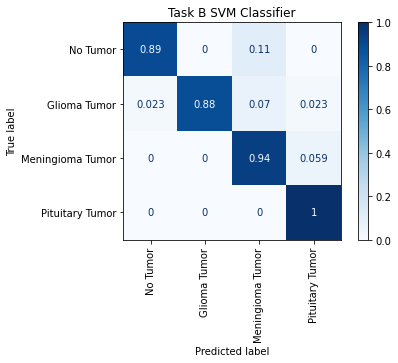

In [10]:
fig, ax = plt.subplots()
metrics.ConfusionMatrixDisplay.from_predictions(
    Test_Tumor,
    Tumor_Prediction,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax,
    display_labels=['No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor'],
    xticks_rotation = 'vertical'
)
ax.set_title('Task B SVM Classifier')

# Classification Report

In [11]:
print(metrics.classification_report(
    Test_Tumor, Tumor_Prediction, target_names=['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']))
pandas.set_option('display.max_colwidth', None)
display(results)

                  precision    recall  f1-score   support

        No tumor       0.97      0.89      0.93        37
    Glioma Tumor       1.00      0.88      0.94        43
Meningioma Tumor       0.90      0.94      0.92        68
 Pituitary Tumor       0.91      1.00      0.95        52

        accuracy                           0.94       200
       macro avg       0.95      0.93      0.94       200
    weighted avg       0.94      0.94      0.93       200



,params,mean_train_score,mean_test_score,rank_test_score
46,"{'pca__n_components': 0.97, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.912709,1
45,"{'pca__n_components': 0.97, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.912709,1
44,"{'pca__n_components': 0.97, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.834783,3
43,"{'pca__n_components': 0.97, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.834783,3
42,"{'pca__n_components': 0.97, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.834783,3
37,"{'pca__n_components': 0.97, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.743624,6
38,"{'pca__n_components': 0.97, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.743624,6
36,"{'pca__n_components': 0.97, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.743624,6
40,"{'pca__n_components': 0.96, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.742282,9
41,"{'pca__n_components': 0.96, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",1.0,0.742282,9
